In [93]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sample_sub = pd.read_csv("../data/sample_submit.csv")
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("../data/genre_labels.csv")

In [95]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

In [96]:
# feature engineering

df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

df["num_nans"] = 0
for col in ["acousticness", "positiveness", "danceability", "energy", "liveness", "speechiness", "instrumentalness"]:
    df["num_nans"] += df[col].isna()

In [97]:
# feature scaling

df["log_tempo"] = np.log(df["tempo"])
for col in ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo', 'num_nans']:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [98]:
df_train, df_test = split_train_test(df)
target = df_train["genre"]

In [99]:
# feature weights

features = ['region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F', 'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L', 'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R', 'region_S', 'region_T', 'region_unknown', 'standardscaled_popularity', 'standardscaled_duration_ms', 'standardscaled_acousticness', 'standardscaled_positiveness', 'standardscaled_danceability', 'standardscaled_loudness', 'standardscaled_energy', 'standardscaled_liveness', 'standardscaled_speechiness', 'standardscaled_instrumentalness', 'standardscaled_log_tempo', 'standardscaled_num_nans']

dict_feature_weights = {}

for col in features[:21]:
    dict_feature_weights[col] = 100.0

for col in ['standardscaled_duration_ms', 'standardscaled_acousticness', 'standardscaled_positiveness', 'standardscaled_danceability', 'standardscaled_loudness', 'standardscaled_energy', 'standardscaled_liveness', 'standardscaled_speechiness', 'standardscaled_instrumentalness']:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

feature_weights = np.array([dict_feature_weights[col] for col in features])

In [100]:
# parameters

N_CLASSES = 11
n_neighbors = 6

f1_score=0.6524753599245727

              precision    recall  f1-score   support

           0       0.86      0.59      0.70        32
           1       0.56      0.37      0.44       205
           2       0.67      0.60      0.63       191
           3       0.82      0.71      0.76       362
           4       0.69      0.64      0.67        45
           5       0.67      0.49      0.57       126
           6       0.68      0.34      0.45        50
           7       0.63      0.58      0.60       334
           8       0.70      0.79      0.75      1305
           9       0.75      0.88      0.81        59
          10       0.77      0.81      0.79      1337

    accuracy                           0.72      4046
   macro avg       0.71      0.62      0.65      4046
weighted avg       0.72      0.72      0.72      4046



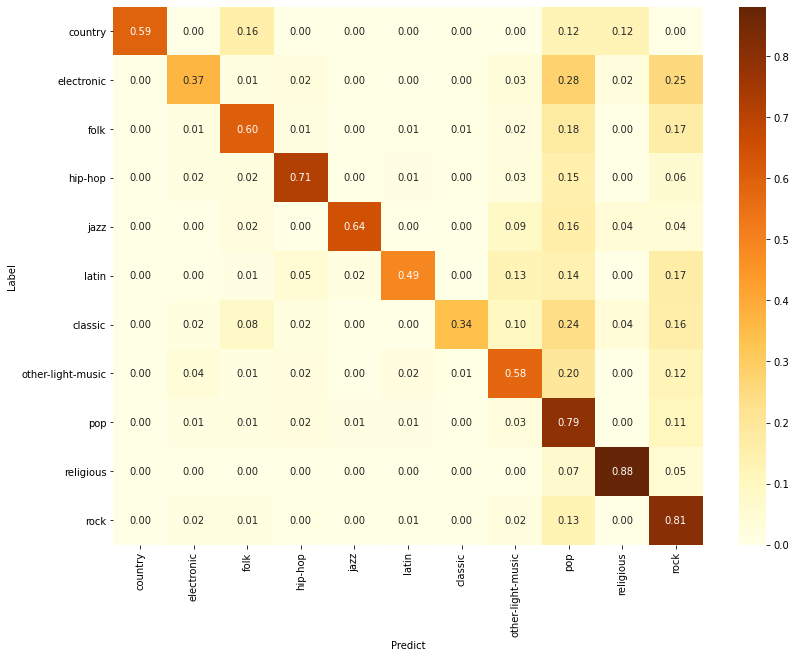

In [101]:
def visualize_confusion_matrix(y_true, pred_label, height=.6, labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true, y_pred=pred_label, normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

# cross validation
def calc_loo_cv_score():  # leave-one-out
    model = KNeighborsClassifier(n_neighbors + 1, weights="distance")
    X = df_train[features].fillna(0.0).values * feature_weights
    model.fit(X, target)
    distances, indexes = model.kneighbors(X)
    distances = distances[:, 1:]
    indexes = indexes[:, 1:]
    labels = target.values[indexes]
    preds = np.array([np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)]).argmax(1)
    score = f1_score(target, preds, average="macro")
    print(f"f1_score={score}\n")
    print(classification_report(target, preds))
    
    fig = visualize_confusion_matrix(target, preds, labels=df_genre_labels["genre"])
    plt.show(fig)

    
calc_loo_cv_score()

In [102]:
# prediction for test data

model = KNeighborsClassifier(n_neighbors)
X_train = df_train[features].fillna(0.0).values * feature_weights
X_test = df_test[features].fillna(0.0).values * feature_weights
model.fit(X_train, target)
y_test = model.predict(X_test)
# df_submission = df_sample_sub.copy()
# df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
# assert not df_submission["genre"].isna().any()
# df_submission.head(10)

In [103]:
# Store csv file
sample_submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit = pd.concat([sample_submit.iloc[:, 0], pd.Series(y_test)], axis=1)

In [104]:
submit

,0,0
0,4046,7
1,4047,8
2,4048,10
3,4049,8
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,1
4044,8090,8


In [90]:
# submit.to_csv("../logs/knn_baseline.csv", header=None, index=None)

In [106]:
df_train[features]

,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,...,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,standardscaled_log_tempo,standardscaled_num_nans
0,0,0,0,0,0,0,0,1,0,0,...,-0.955307,-1.385544,-1.962862,1.430045,1.432573,0.614576,2.232172,4.337850,0.549758,-0.049673
1,0,0,0,0,0,0,0,0,1,0,...,-1.003394,-0.535914,0.329522,0.525867,1.335430,-0.470388,-0.455130,-0.588410,1.269242,-0.049673
2,0,0,0,0,1,0,0,0,0,0,...,0.651814,-0.900207,-0.275784,-0.390048,-0.827926,-0.321693,1.984717,-0.314336,-2.025425,-0.049673
3,0,0,1,0,0,0,0,0,0,0,...,-0.733869,-0.989328,-0.907740,0.638890,1.307025,0.700620,0.311054,-0.256833,1.711681,-0.049673
4,0,0,0,0,0,0,0,0,0,0,...,-0.628908,1.398433,2.055585,0.924070,0.218791,-0.627489,0.261813,0.069220,-0.335492,-0.049673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,0,0,0,0,0,0,0,0,0,0,...,-0.888345,-0.611512,0.463255,0.598453,-0.481382,-0.471091,-0.151454,-0.367613,0.549758,-0.049673
4042,0,0,0,1,0,0,0,0,0,0,...,1.834557,-1.064617,-0.671969,-1.617309,-1.410802,-0.091741,-0.693499,0.517282,0.549758,-0.049673
4043,0,0,0,0,1,0,0,0,0,0,...,0.256457,-0.016165,1.066264,-0.749479,0.200971,-0.251081,-0.563586,-0.333572,-0.335492,-0.049673
4044,0,0,0,0,0,0,0,0,0,0,...,-0.556115,-0.002088,0.136116,-0.044411,-0.484471,-0.125551,0.023778,-0.032827,-1.209295,-0.049673
